<a href="https://colab.research.google.com/github/balawillgetyou/dy/blob/master/StateFarmDistractedDriverDetection_FeatureExtractionVsFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download kaggle.json from Kaggle -- MyAccount -- Create New API Token - auto downloads as "kaggle.json
#Import json into notebook - run in a cell 
from google.colab import files
files.upload()

#Browse to downloaded kaggle.json and upload

In [ ]:
#Setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
#Verify json content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [ ]:
#Install kaggle packages
!pip install -q kaggle

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

 99% 3.98G/4.00G [00:27<00:00, 158MB/s]
100% 4.00G/4.00G [00:27<00:00, 156MB/s]


In [ ]:
import os
os.chdir('/content')
!ls -d $PWD/*

/content/kaggle.json  /content/state-farm-distracted-driver-detection.zip
/content/sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('state-farm-distracted-driver-detection.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
train_dir = "imgs/train"
train_class=os.listdir(train_dir)
print(train_class)

test_dir = "imgs/test"
test_class=train_class
print(test_class)

['c4', 'c1', 'c0', 'c6', 'c8', 'c3', 'c5', 'c9', 'c7', 'c2']
['c4', 'c1', 'c0', 'c6', 'c8', 'c3', 'c5', 'c9', 'c7', 'c2']


In [ ]:
#creating useful labels
classes = ('Safe driving', 
           'Texting - right', 
           'Talking on the phone - right', 
           'Texting - left', 
           'Talking on the phone - left', 
           'Operating the radio', 
           'Drinking', 
           'Reaching behind', 
           'Hair and makeup', 
           'Talking to passenger')

In [ ]:
#number of files across all sub folders
!find . -type f | wc -l

102173


In [ ]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image preview

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

def im_transform(train_size=100*10, test_size=100*10):
    transform = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

    training_dataset = datasets.ImageFolder('imgs/train', transform=transform)

    indices = np.arange(len(training_dataset))
    train_indices, test_indices = train_test_split(indices, train_size=train_size, test_size=test_size, stratify=training_dataset.targets)

    # Wrap into Subsets and DataLoaders
    train_dataset = Subset(training_dataset, train_indices)
    test_dataset = Subset(training_dataset, test_indices)

    print(len(train_dataset), len(test_dataset))

    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
    return training_loader, validation_loader

In [ ]:
training_loader, validation_loader = im_transform(train_size=5*10, test_size=5*10)

50 50


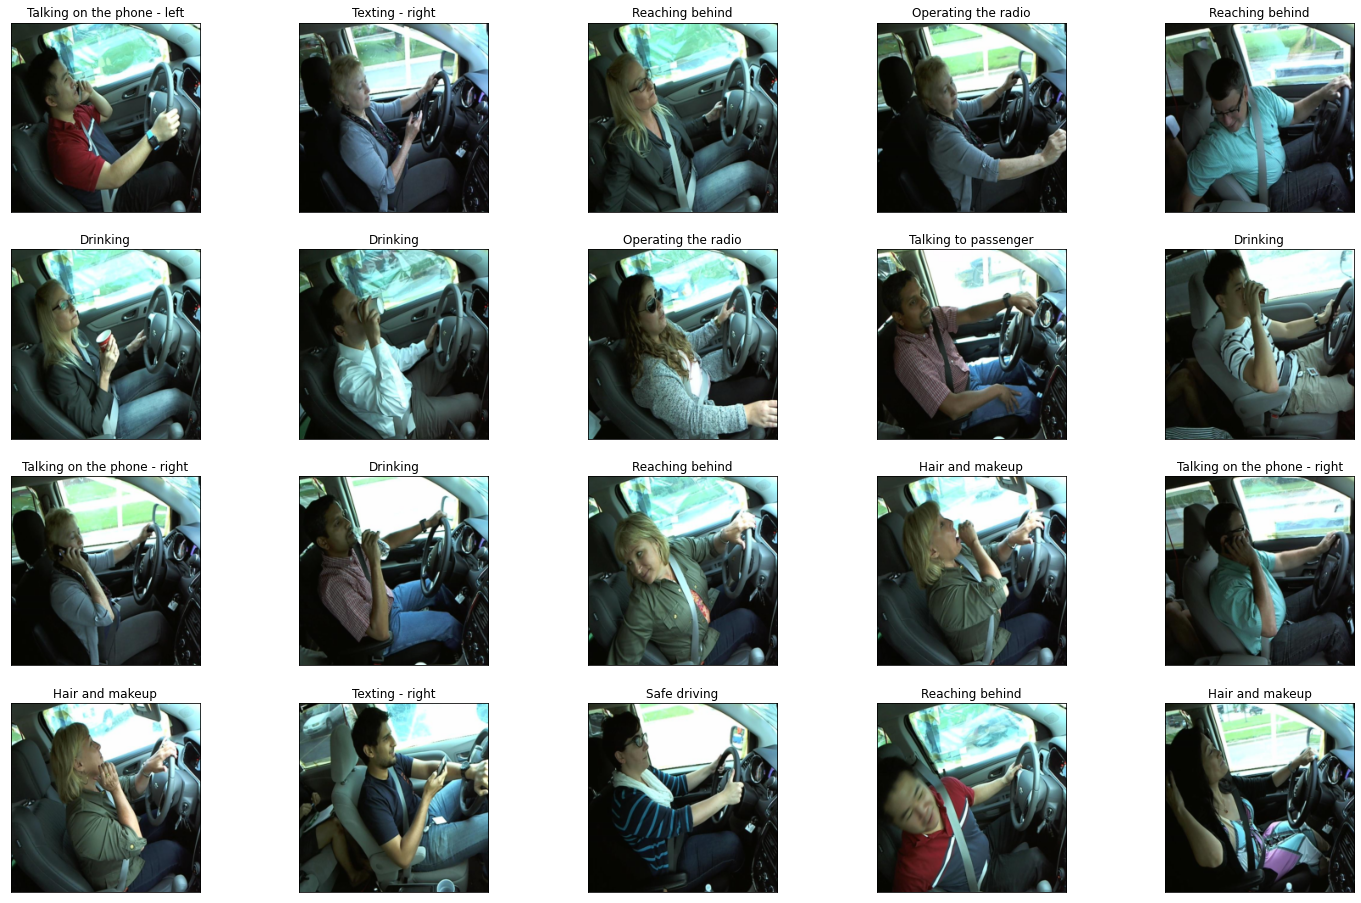

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 16))

for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

# Examining the pre-trained VGG-16 model 
The VGG model is already trained on 1.2 million images to classify into 1,000 classes. The architectural details are shown below. Note that classifier[6] is the final fully connected layer.  
![VGG-NETS](https://pytorch.org/assets/images/vgg.png)

In [ ]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

This model can be used in either the (1) feature extraction mode or (2) the fine-tuning mode.    
![CNN schema](https://www.researchgate.net/publication/331540139/figure/fig4/AS:733273504354306@1551837435967/The-overall-architecture-of-the-Convolutional-Neural-Network-CNN-includes-an-input.png)

In [ ]:
def train_model(model, criterion, optimizer, training_loader, validation_loader, epochs = 5):
  epochs = 5
  running_loss_history = []
  running_corrects_history = []
  val_running_loss_history = []
  val_running_corrects_history = []
  #for final scoring
  val_labels_list = []
  val_preds_list = []

  for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data)
        
      epoch_loss = running_loss/len(training_loader.dataset)
      epoch_acc = running_corrects.float()/ len(training_loader.dataset)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
      
      val_epoch_loss = val_running_loss/len(validation_loader.dataset)
      val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1))
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

      #scoring
      val_labels_list.append(val_labels)
      val_preds_list.append(val_preds)
      preds_list_processed = [x.to("cpu").numpy() for x in val_preds_list]
      labels_list_processed = [x.to("cpu").numpy() for x in val_labels_list]

      preds_list_processed = list(itertools.chain.from_iterable(preds_list_processed))
      labels_list_processed = list(itertools.chain.from_iterable(labels_list_processed))

      return preds_list_processed, labels_list_processed


In [ ]:
def execute_pipeline(model, mode='Feature Extraction', train_size=100*10, test_size=100*10, epochs=5):
  #configuring the pre-trained model
  if mode == 'Feature Extraction': 
    #Note how all parameters (weights and bias) are first frozen with the param.requires_grad_(False) command. 
    for param in model.parameters():
      param.requires_grad_(False)
    #irrespective of mode the last layer has to be modified 
    #classifier[6] is the current last layer, pretrained to classify into 1,000 classes, but we need to classify to 10 classes
    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(classes))
    model.classifier[6] = last_layer
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr = 0.0001)#note that only the final fully connected layer's parameters are being updated
    print('Configured the pre-trained model for Feature Extraction mode')
  else:#alternative being "Fine Tuning"
    #irrespective of mode the last layer has to be modified 
    #classifier[6] is the current last layer, pretrained to classify into 1,000 classes, but we need to classify to 10 classes
    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(classes))
    model.classifier[6] = last_layer
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)#note how all the parameters are being updated
    print('Configured the pre-trained model for Fine Tuning mode')

  #processing the data
  training_loader, validation_loader = im_transform(train_size, test_size)
  print('Processed the data')

  #model training
  preds_list_processed, labels_list_processed = train_model(model, criterion, optimizer, training_loader, validation_loader, epochs)
  print('Model trained')

  #model scoring
  print(classification_report(labels_list_processed, preds_list_processed, target_names=classes))

  return preds_list_processed, labels_list_processed


# Validating approach with a small subset of data  

In [ ]:
model = models.vgg16(pretrained=True)
preds_list_processed, labels_list_processed = execute_pipeline(model, mode='Feature Extraction', train_size=10*10, test_size=10*10, epochs=1)

Configured the pre-trained model for Feature Extraction mode
100 100
Processed the data
epoch : 1
training loss: 0.0190, acc 0.0960 
validation loss: 0.0189, validation acc 0.1170 
Model trained
                              precision    recall  f1-score   support

                Safe driving       0.23      0.27      0.25        11
             Texting - right       0.11      0.08      0.09        13
Talking on the phone - right       0.20      0.15      0.17        13
              Texting - left       0.00      0.00      0.00         6
 Talking on the phone - left       0.22      0.40      0.29         5
         Operating the radio       0.18      0.14      0.16        14
                    Drinking       0.25      0.19      0.21        16
             Reaching behind       0.33      0.25      0.29        12
             Hair and makeup       0.00      0.00      0.00         7
        Talking to passenger       0.12      0.14      0.13         7

                    accuracy     

In [ ]:
model = models.vgg16(pretrained=True)
preds_list_processed, labels_list_processed = execute_pipeline(model, mode='Fine Tuning', train_size=5*10, test_size=5*10, epochs=1)

Configured the pre-trained model for Fine Tuning mode
100 100
Processed the data
epoch : 1
training loss: 0.0483, acc 0.0800 
validation loss: 0.0464, validation acc 0.1200 
Model trained
                              precision    recall  f1-score   support

                Safe driving       0.08      0.17      0.11         6
             Texting - right       0.00      0.00      0.00         5
Talking on the phone - right       0.00      0.00      0.00         5
              Texting - left       0.12      0.20      0.15         5
 Talking on the phone - left       0.10      0.20      0.13         5
         Operating the radio       0.50      0.20      0.29         5
                    Drinking       0.00      0.00      0.00         5
             Reaching behind       0.25      0.20      0.22         5
             Hair and makeup       0.50      0.25      0.33         4
        Talking to passenger       0.00      0.00      0.00         5

                    accuracy            

# With the full dataset of ~20,000 images 

In [ ]:
model = models.vgg16(pretrained=True)
preds_list_processed, labels_list_processed = execute_pipeline(model, mode='Feature Extraction', train_size=1700*10, test_size=300*10, epochs=5)

Configured the pre-trained model for Feature Extraction mode
17000 3000
Processed the data


In [ ]:
model = models.vgg16(pretrained=True)
preds_list_processed, labels_list_processed = execute_pipeline(model, mode='Fine Tuning', train_size=1700*10, test_size=300*10, epochs=5)